# Because You Watched

Using KMeans to group movies by genre

## Setup And Exploration

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Set default seed
np.random.seed(2802)

In [2]:
movies = pd.read_csv('datasets/movielens_100k/movies.csv')

movies.columns = ['movie_id', 'title', 'genres']
movies = movies.set_index('movie_id')

movies.head()

,title,genres
movie_id,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


## Extracting Features

### Get Dummies From Genres

In [3]:
X = movies['genres'].str.get_dummies().to_sparse()

In [4]:
X = X.rename(columns={'(no genres listed)': 'Missing'})
X.head()

,Missing,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
movies = pd.concat([movies, X], axis=1).to_sparse()
movies.head()

,title,genres,Missing,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Missing Values

In [6]:
movies[movies['Missing'] == 1].shape

(34, 22)

In [7]:
movies = movies.drop(movies[movies['Missing'] == 1].index)
movies = movies.drop('Missing', axis=1)

movies.shape

(9708, 21)

In [8]:
X = X.drop(X[X['Missing'] == 1].index)
X = X.drop('Missing', axis=1)

X.shape

(9708, 19)

## Pre-Processing Data

### Scaling Data

In [9]:
from sklearn.preprocessing import StandardScaler

# Find the most relevant genres by movie
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled

c:\python37\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype Sparse[int64, nan] were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python37\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype Sparse[int64, nan] were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-0.48164271,  2.58581918,  3.85858874, ..., -0.49232658,
        -0.20238764, -0.13230044],
       [-0.48164271,  2.58581918, -0.25916211, ..., -0.49232658,
        -0.20238764, -0.13230044],
       [-0.48164271, -0.38672464, -0.25916211, ..., -0.49232658,
        -0.20238764, -0.13230044],
       ...,
       [-0.48164271, -0.38672464, -0.25916211, ..., -0.49232658,
        -0.20238764, -0.13230044],
       [ 2.07622785, -0.38672464,  3.85858874, ..., -0.49232658,
        -0.20238764, -0.13230044],
       [-0.48164271, -0.38672464, -0.25916211, ..., -0.49232658,
        -0.20238764, -0.13230044]])

## Model Tune

### Elbow Method

In [10]:
from sklearn.cluster import KMeans

def elbow(n_clusters):
    model = KMeans(n_clusters=n_clusters)
    model.fit(X_scaled)

    return [n_clusters, model.inertia_]

In [11]:
max_clusters = 40 # Using 40 clusters to elbow method

errors_by_group = [elbow(n_clusters) for n_clusters in range(1, max_clusters + 1)]
errors_by_group = pd.DataFrame(errors_by_group, columns=['group', 'error'])

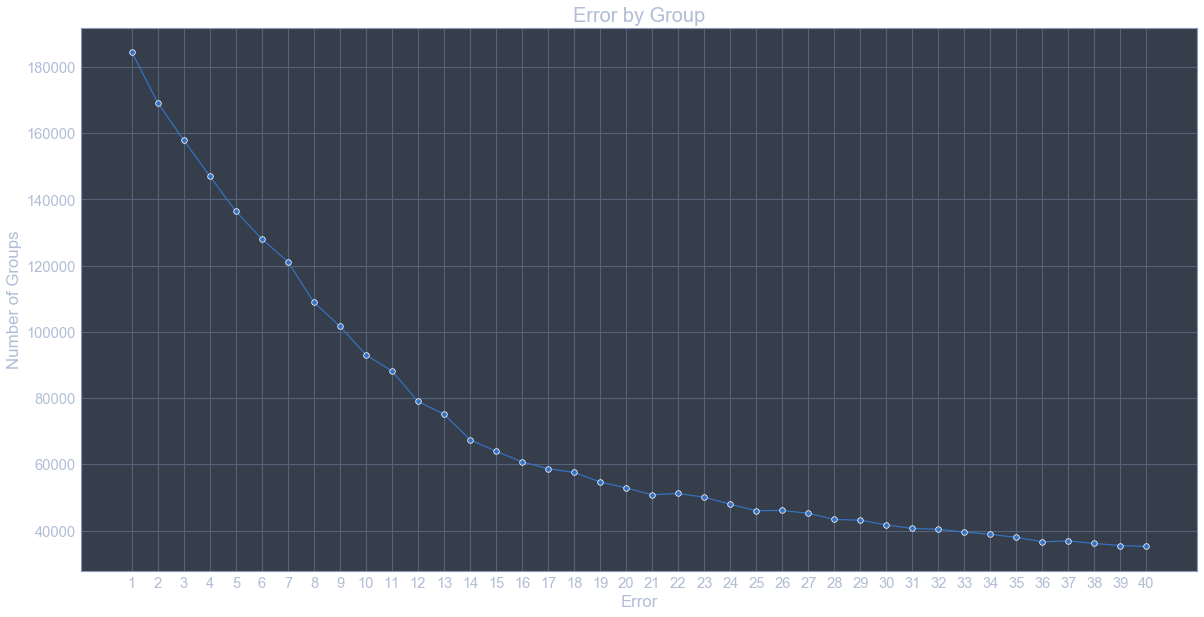

In [12]:
def plot_elbow(line_markers=[]):
    plt.figure(figsize=(20, 10))

    ax = sns.lineplot(data=errors_by_group, x='group', y='error',
                      style=True, markers=True, legend=None)

    ax.set_title('Error by Group', fontsize=20)
    ax.set_ylabel('Number of Groups')
    ax.set_xlabel('Error')
    ax.set_xticks(errors_by_group['group'])

    for line in line_markers:
        plt.axvline(x=line, linewidth=3, c='r')
    
    ax
    
plot_elbow()

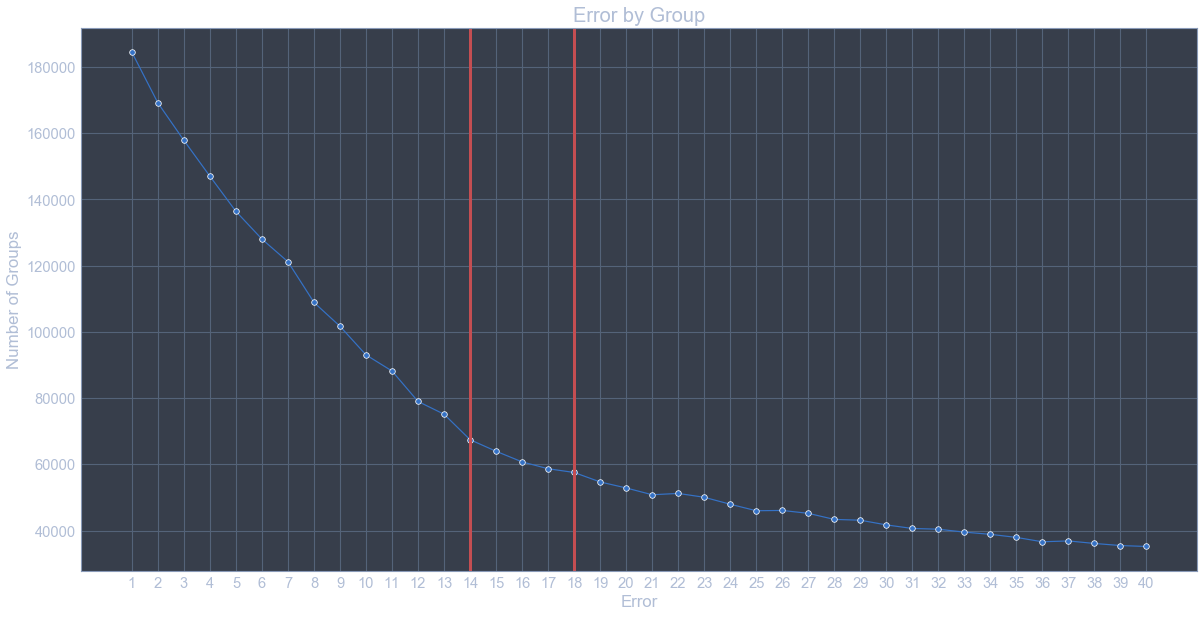

In [13]:
interval = np.array([14, 18])
plot_elbow(interval)

In [14]:
n_clusters = 16

Best number of clusters: {{ n_clusters }} 

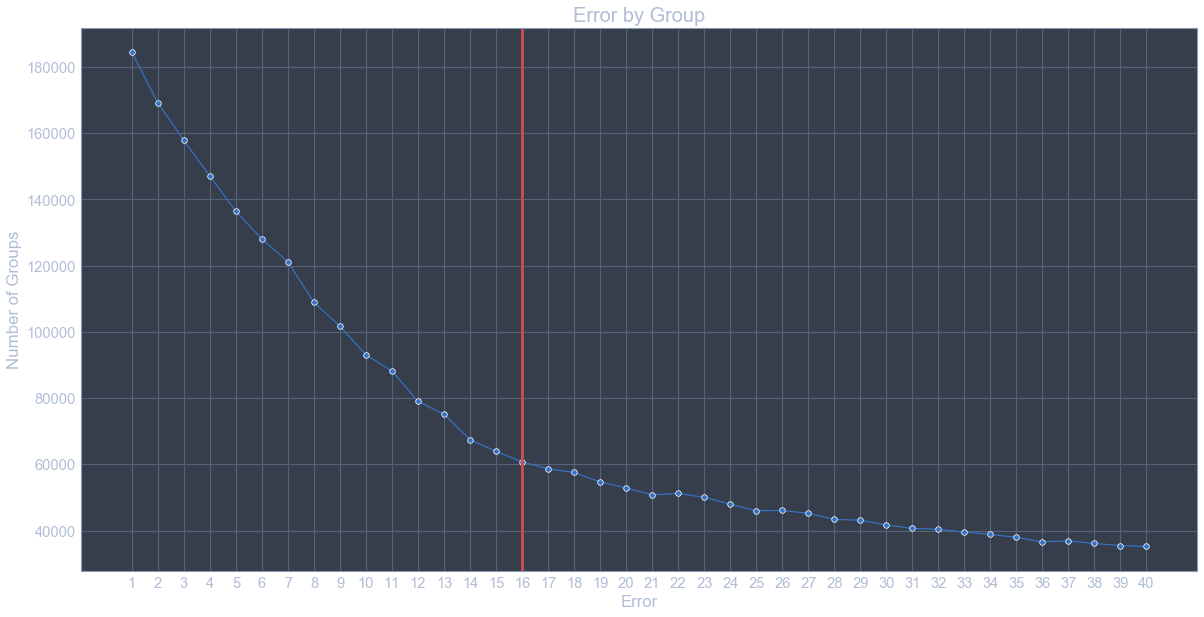

In [15]:
plot_elbow([interval.mean()])

## Fit The Best Model

In [16]:
model = KMeans(n_clusters=n_clusters)
groups = model.fit_predict(X_scaled)

groups = pd.DataFrame(model.cluster_centers_, columns=X.columns)
groups.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.167884,0.875771,-0.259162,0.610375,0.146866,-0.300249,-0.217888,-0.279656,3.385577,-0.095093,-0.021129,-0.128625,-0.18876,-0.202774,0.089986,-0.036713,-0.322203,-0.202388,-0.1323
1,-0.434316,-0.281965,-0.259162,-0.239546,0.480963,-0.327178,-0.217888,0.303133,-0.295371,-0.095093,-0.334705,-0.128625,-0.18876,-0.250451,2.254486,-0.276594,-0.438966,-0.202388,-0.1323
2,0.399883,0.033126,-0.201002,-0.259768,-0.469582,-0.298108,-0.190728,0.743830,-0.243380,-0.095093,-0.306549,-0.128625,-0.18876,-0.214491,-0.054859,-0.231940,-0.200057,4.941013,-0.1323
3,-0.334656,-0.224714,-0.259162,0.052912,1.225993,-0.375379,-0.217888,-0.337383,-0.295371,-0.095093,-0.334705,-0.128625,-0.18876,-0.250451,-0.443560,-0.335086,-0.448973,-0.202388,-0.1323
4,-0.139464,-0.343416,-0.253708,-0.265712,-0.397339,-0.214354,-0.217888,-0.607536,-0.178360,-0.095093,2.987705,-0.128625,-0.18876,-0.250451,-0.379236,0.434311,0.640741,-0.202388,-0.1323


## Exploring Groups

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020DCABED550>,
      dtype=object)

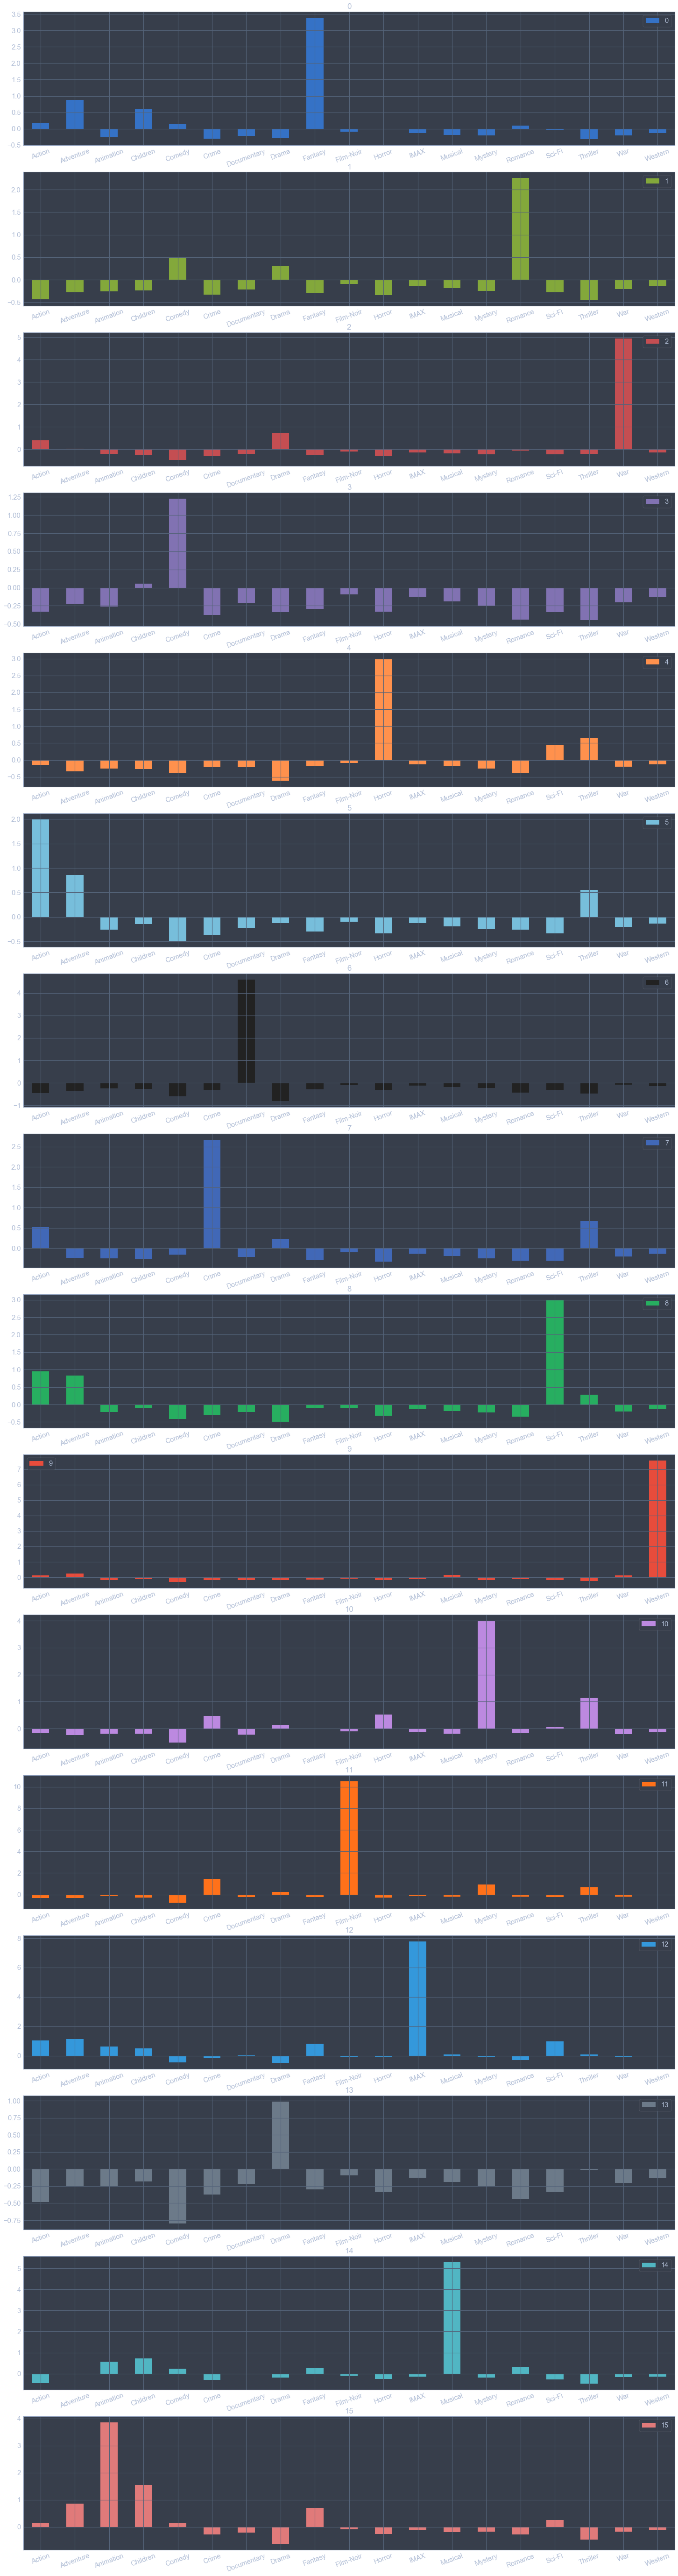

In [17]:
transposed_groups = groups.transpose()
transposed_groups.plot.bar(subplots=True, figsize=(25, 100), sharex=False, rot=20)

In [18]:
groups_by_genres = {}
for group in transposed_groups.columns:
    genres = transposed_groups[group].nlargest(3)
    groups_by_genres[group] = list(genres.index)

groups_by_genres

{0: ['Fantasy', 'Adventure', 'Children'],
 1: ['Romance', 'Comedy', 'Drama'],
 2: ['War', 'Drama', 'Action'],
 3: ['Comedy', 'Children', 'Film-Noir'],
 4: ['Horror', 'Thriller', 'Sci-Fi'],
 5: ['Action', 'Adventure', 'Thriller'],
 6: ['Documentary', 'War', 'Film-Noir'],
 7: ['Crime', 'Thriller', 'Action'],
 8: ['Sci-Fi', 'Action', 'Adventure'],
 9: ['Western', 'Adventure', 'Musical'],
 10: ['Mystery', 'Thriller', 'Horror'],
 11: ['Film-Noir', 'Crime', 'Mystery'],
 12: ['IMAX', 'Adventure', 'Action'],
 13: ['Drama', 'Thriller', 'Film-Noir'],
 14: ['Musical', 'Children', 'Animation'],
 15: ['Animation', 'Children', 'Adventure']}

In [19]:
from functools import reduce

def to_group_title(acc, group):
    acc[group] = ', '.join(groups_by_genres[group])
    return acc

groups_by_genres_and_titles = reduce(to_group_title, groups_by_genres.keys(), {})
groups_by_genres_and_titles = pd.DataFrame.from_dict(groups_by_genres_and_titles,
                                                     orient='index', columns=['genres'])
groups_by_genres_and_titles.index.name = 'group'

groups_by_genres_and_titles

,genres
group,
0,"Fantasy, Adventure, Children"
1,"Romance, Comedy, Drama"
2,"War, Drama, Action"
3,"Comedy, Children, Film-Noir"
4,"Horror, Thriller, Sci-Fi"
5,"Action, Adventure, Thriller"
6,"Documentary, War, Film-Noir"
7,"Crime, Thriller, Action"
8,"Sci-Fi, Action, Adventure"


In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
plot = tsne.fit_transform(X_scaled)

plot

array([[ 46.933594, -39.2933  ],
       [-45.521503,  41.246277],
       [-21.749859,  28.705631],
       ...,
       [ -8.317203, -16.769793],
       [ 30.741018, -14.714273],
       [ 10.170786,  18.446213]], dtype=float32)

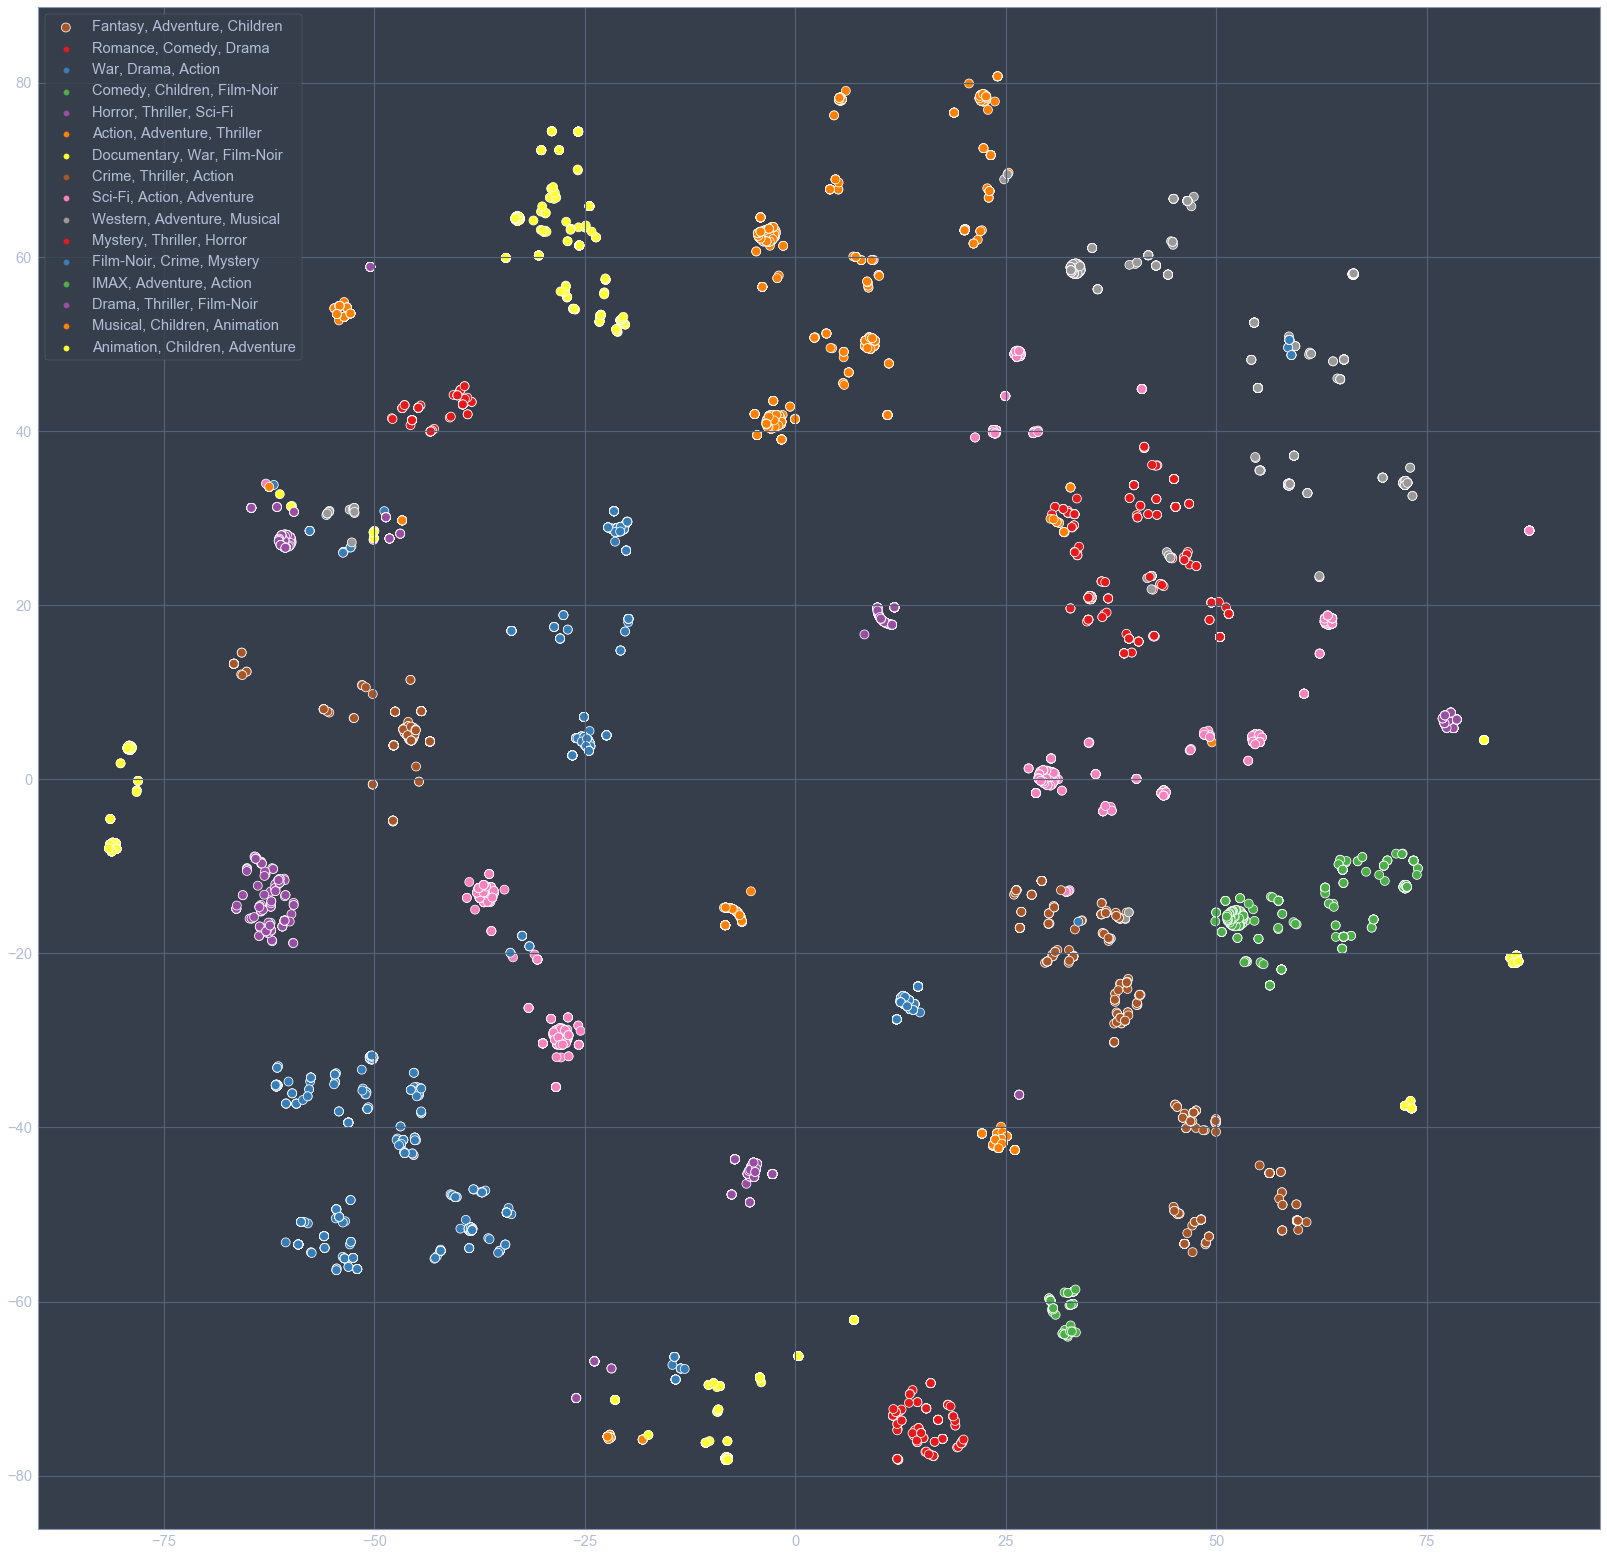

In [21]:
plt.figure(figsize=(28, 28))
ax = sns.scatterplot(x=plot[:, 0],
                     y=plot[:, 1],
                     s=80,
                     hue=model.labels_,
                     palette=sns.color_palette('Set1', n_clusters))
ax.legend(groups_by_genres_and_titles['genres'])

ax

In [22]:
grouped_movies = pd.DataFrame({'movie_id': movies.index,
                               'group': model.labels_})

grouped_movies.set_index('group', inplace=True)
grouped_movies.shape

(9708, 1)

In [23]:
grouped_movies = grouped_movies.join(groups_by_genres_and_titles)

grouped_movies.reset_index(inplace=True)
grouped_movies.set_index('movie_id', inplace=True)

grouped_movies.shape

(9708, 2)

In [24]:
grouped_movies = grouped_movies.join(movies['title'])
grouped_movies.head()

,group,genres,title
movie_id,,,
2,0,"Fantasy, Adventure, Children",Jumanji (1995)
44,0,"Fantasy, Adventure, Children",Mortal Kombat (1995)
60,0,"Fantasy, Adventure, Children","Indian in the Cupboard, The (1995)"
126,0,"Fantasy, Adventure, Children","NeverEnding Story III, The (1994)"
189,0,"Fantasy, Adventure, Children",Reckless (1995)


In [25]:
# 1 => Toy Story
grouped_movies.loc[1]

group                                 15
genres    Animation, Children, Adventure
title                   Toy Story (1995)
Name: 1, dtype: object

# Recommending Movies

## By Similarity [Test Only]

In [26]:
def recommend_by_similarity(movie_id, n_recommendations=3, min_similarity=2, samples=None):
    movie = movies.loc[movie_id]
    title = movie['title']
    print(f'Because you watched: {title}')
    
    movie_genres = set()

    for genre in movie.index:
        if genre not in transposed_groups.index:
            continue

        group = movie[genre]
        if group != 1:
            continue

        movie_genres.add(genre)
        
    found_groups = []
    similarities = []
    
    for group, group_genres in groups_by_genres.items():
        is_part_of_group = any(genre in movie_genres
                               for genre in group_genres)
        
        if is_part_of_group:
            found_groups.append(group_genres)
    
        genres_set = set(group_genres)
        
        genres = movie_genres.intersection(genres_set)
        similarities.append({'group': group,
                             'similarity': len(genres)})

    similarities = sorted(similarities, key=lambda k: k['similarity'], reverse=True)
    similarities = filter(lambda x: x['similarity'], similarities)
    similarities = map(lambda s: s['group'], similarities)  

    similar_movies = set()
    
    movies_data = movies
    if samples:
        movies_data = movies.sample(100)
    
    count = 0
    for idx, movie in movies_data.iterrows():
        if count >= n_recommendations:
            break
        
        similar = 0
        for genre in movie_genres:
            if movie_id == idx:
                continue

            similar += movie[genre]
            if similar < min_similarity:
                continue

            similar_movies.add(movie['title'])
            count += 1
    
    return list(similar_movies)

In [27]:
# 1 => Toy Story
recommendations = recommend_by_similarity(1, min_similarity=3, n_recommendations=20)
recommendations

Because you watched: Toy Story (1995)


['NeverEnding Story III, The (1994)',
 'Jumanji (1995)',
 'Indian in the Cupboard, The (1995)',
 'Gordy (1995)',
 'Nightmare Before Christmas, The (1993)',
 'Goofy Movie, A (1995)',
 'Balto (1995)',
 'Flintstones, The (1994)',
 'Super Mario Bros. (1993)',
 'Lion King, The (1994)',
 'Muppet Treasure Island (1996)',
 'Addams Family Values (1993)',
 'Last Action Hero (1993)',
 "Kid in King Arthur's Court, A (1995)"]

## By Other Members Of Group

In [28]:
def recommend_movies_on_the_same_group(movie_id, n_recommendations=3, samples=None):
    movie = grouped_movies.loc[movie_id][['title', 'group']]
    
    title = movie['title']
    group = movie['group']
    
    print(f'Because you watched: {title}')
    
    grouped_data = grouped_movies
    if samples:
        grouped_data = grouped_movies.sample(samples)
    
    movies_on_the_same_group = grouped_data[grouped_data['group'] == group].sample(n_recommendations)
    movies_ids = movies_on_the_same_group.index
    
    movies_titles = movies.loc[movies_ids]['title']
    
    return list(movies_titles)

In [29]:
# 1 => Toy Story
recommendations = recommend_movies_on_the_same_group(1, n_recommendations=20)
recommendations

Because you watched: Toy Story (1995)


['Only Yesterday (Omohide poro poro) (1991)',
 "Piglet's Big Movie (2003)",
 'Mystery of the Third Planet, The (Tayna tretey planety) (1981)',
 "Mickey's Once Upon a Christmas (1999)",
 'Blood: The Last Vampire (2000)',
 'Kung Fu Panda: Secrets of the Masters (2011)',
 "Kid's Story (2003)",
 'Turbo (2013)',
 'Kung Fu Panda 3 (2016)',
 'Charlie Brown Christmas, A (1965)',
 'My Life as McDull (Mak dau goo si) (2001)',
 'Winnie the Pooh (2011)',
 'Escape from Planet Earth (2013)',
 "Last Year's Snow Was Falling (1983)",
 'Time Masters (Maîtres du temps, Les) (1982)',
 'Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002)',
 'Kingsglaive: Final Fantasy XV (2016)',
 'Bobik Visiting Barbos (1977)',
 'Despicable Me 3 (2017)',
 'Hotel Transylvania (2012)']

*Notes:*

This model is limited to recommend movies only in the same group.

# Saving Model

In [30]:
import pickle

def save_model(filepath, fitted_model):
    try:
        with open(filepath, 'wb') as f:
            pickle.dump(fitted_model, f)
    except Exception as e:
        print(e)

        
def load_model(filepath):
    fitted_model = None
    try:
        with open(filepath, 'rb') as f:
            fitted_model = pickle.load(f)
            
        return fitted_model
    except Exception as e:
        print(e)

In [31]:
filename = 'kmeans_movies_cluster.pkl'
filepath = f'models/{filename}'

save_model(filepath, model)